# Finding PI

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chattopadhyayA/ml_for_physics/blob/master/content/07_findingPI.ipynb)

### The Monte Carlo Approach

Before trying with machine learning, let us first use the Monte Carlo method for estimating $\pi$. In simple words, whenever any computer algorithm involves repeated random sampling to generate some numerical results, we can safely call that a Monte Carlo simulation. 

The concept is simple: imagine randomly tossing darts at a dartboard mounted to a square. Now if we are *random enough*, one can assume that the random darts are uniformly distributed over the square. In that case the number of points inside some region inside the square should be proportional to the area of that region. Then, $\pi$ can be approximated by four times the number of darts hitting the dartboard divided by the total number of darts thrown.

> The ratio of a circle’s area ($\pi r^2$) with that to the area of a square ($4 r^2$) is $\frac{\pi}{4}$. With a unit circle, we measure the fraction $\frac{\pi}{4}$ through randomness.

Estimated value of PI: 3.1448


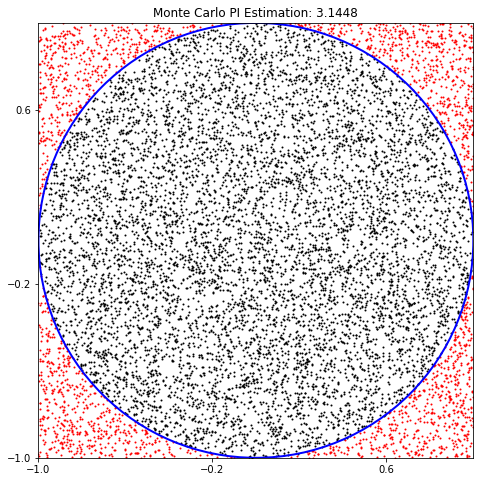

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Number of random points
N = 10000

# Generate random points in the square [-1, 1] x [-1, 1]
x = np.random.uniform(-1, 1, N) # This have to be uniformly sampled
y = np.random.uniform(-1, 1, N)


# Determine which points are inside the circle
circled = x**2 + y**2 <= 1

# Estimate PI: fraction of points inside the circle times four
pi_val = 4 * np.sum(circled) / N

print(f"Estimated value of PI: {pi_val}")

# Plotting
plt.figure(figsize=(8,8))

# Points inside the circle in blue
plt.scatter(x[circled], y[circled], color='black', s=1, label='Inside Circle')
# Points outside the circle in red
plt.scatter(x[~circled], y[~circled], color='red', s=1, label='Outside Circle')

# Draw the circle outline for reference
circle = plt.Circle((0, 0), 1, color='blue', fill=False, linewidth=2, label='Circle')

plt.gca().add_artist(circle)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f"Monte Carlo PI Estimation: {pi_val:.4f}")
# Set ticks to be in increments of 0.8
plt.xticks(np.arange(-1, 1.1, 0.8))
plt.yticks(np.arange(-1, 1.1, 0.8))
plt.show()

### The machine Learning approach

Let us first call the usual libraries for compilation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

- **Main Strategy:** Remember that machine learning is basically learning by example. So in this case we first generate random points on the square and label them as $1$ or $0$ depending on wheather or not the points are inside the circle.

In [3]:
# Generate data
N = 10000
X_data = np.random.uniform(-1, 1, (N, 2)).astype(np.float32)
y_data = ((X_data[:, 0]**2 + X_data[:, 1]**2) <= 1).astype(np.float32) # denote the label of the point whether it is inside the circle or not

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_data)
y_tensor = torch.tensor(y_data).unsqueeze(1)

# Split into training and validation sets (80/20). For most of the cases this is the standard split
val_size = int(0.2 * N)
train_size = N - val_size
dataset = TensorDataset(X_tensor, y_tensor)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512)

- Next step is to define the network or model.

In [4]:
# Define the model

class PiNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), # Defining the layer
            nn.Sigmoid(), # Defining the activation function for the layer
            nn.Linear(32, 32),
            nn.Sigmoid(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = PiNet()

summary(model)

Layer (type:depth-idx)                   Param #
PiNet                                    --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       96
│    └─Sigmoid: 2-2                      --
│    └─Linear: 2-3                       1,056
│    └─Sigmoid: 2-4                      --
│    └─Linear: 2-5                       33
│    └─Sigmoid: 2-6                      --
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0

- Setting up the hyper parameters and other helpers.

In [5]:
# Training setup
criterion = nn.BCELoss() # This is the Binary Cross Entropy loss function, specially used when the target is either 0 or 1.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 200
patience = 15


# For tracking
pi_history = []
val_loss_history = []
decision_boundary_snapshots = []


In [6]:
# Helper functions for estimating PI and plot decision boundary

def estimate_pi(model, val_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for xb, _ in val_loader:
            preds = model(xb) > 0.5
            all_preds.append(preds)
    return 4 * torch.cat(all_preds).float().mean().item()

def plot_decision_boundary(model, epoch):
    model.eval()
    grid_x, grid_y = np.meshgrid(np.linspace(-1, 1, 200), np.linspace(-1, 1, 200))
    grid_points = torch.tensor(np.c_[grid_x.ravel(), grid_y.ravel()], dtype=torch.float32)
    
    with torch.no_grad():
        preds = model(grid_points).numpy().reshape(grid_x.shape)

    plt.figure(figsize=(6, 6))
    plt.contourf(grid_x, grid_y, preds, levels=[0, 0.5, 1], alpha=0.3, colors=['red', 'black'])
    
    X_val_np = val_dataset[:][0].numpy()
    y_val_np = val_dataset[:][1].numpy()
    plt.scatter(X_val_np[y_val_np[:, 0]==1][:, 0], X_val_np[y_val_np[:, 0]==1][:, 1], s=1, c='black')
    plt.scatter(X_val_np[y_val_np[:, 0]==0][:, 0], X_val_np[y_val_np[:, 0]==0][:, 1], s=1, c='red')
    plt.title(f"Epoch {epoch+1}: Decision Boundary (π ≈ {pi_history[-1]:.6f})")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis('equal')
    plt.grid(True)
    plt.show()


- Let us now train the piNet

Epoch 10: Val Loss = 0.5005, π ≈ 4.000000
Epoch 20: Val Loss = 0.4870, π ≈ 4.000000
Epoch 30: Val Loss = 0.2173, π ≈ 3.464000


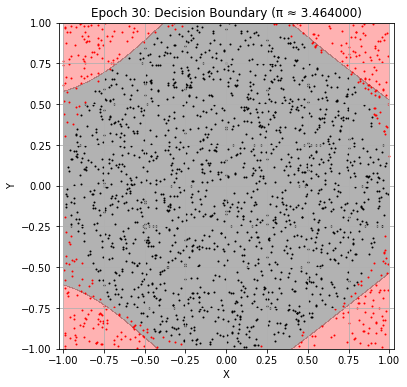

Epoch 40: Val Loss = 0.1147, π ≈ 3.218000
Epoch 50: Val Loss = 0.0938, π ≈ 3.192000
Epoch 60: Val Loss = 0.0782, π ≈ 3.244000


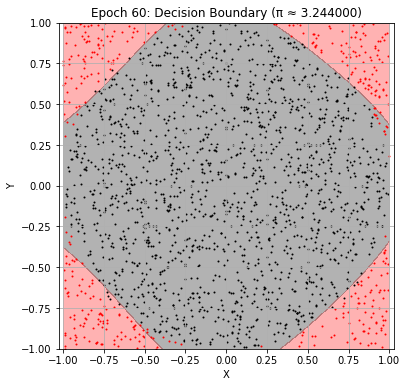

Epoch 70: Val Loss = 0.0701, π ≈ 3.232000
Epoch 80: Val Loss = 0.0638, π ≈ 3.240000
Epoch 90: Val Loss = 0.0582, π ≈ 3.222000


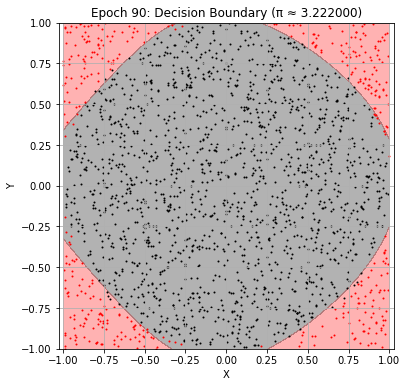

Epoch 100: Val Loss = 0.0540, π ≈ 3.218000
Epoch 110: Val Loss = 0.0500, π ≈ 3.216000
Epoch 120: Val Loss = 0.0465, π ≈ 3.202000


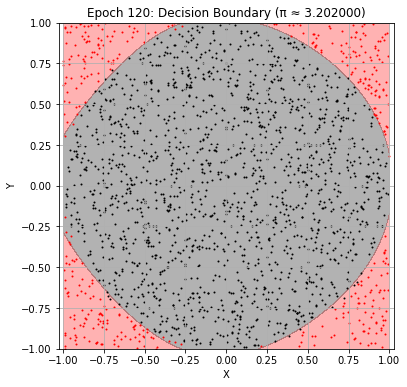

Epoch 130: Val Loss = 0.0446, π ≈ 3.200000
Epoch 140: Val Loss = 0.0441, π ≈ 3.172000
Epoch 150: Val Loss = 0.0381, π ≈ 3.198000


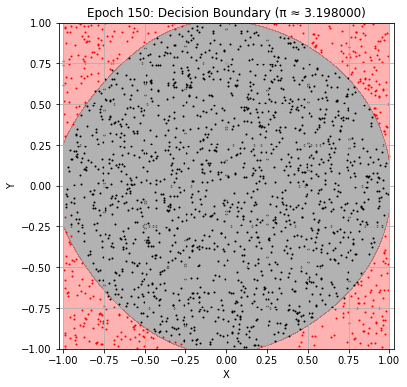

Epoch 160: Val Loss = 0.0373, π ≈ 3.180000
Epoch 170: Val Loss = 0.0353, π ≈ 3.242000
Epoch 180: Val Loss = 0.0328, π ≈ 3.194000


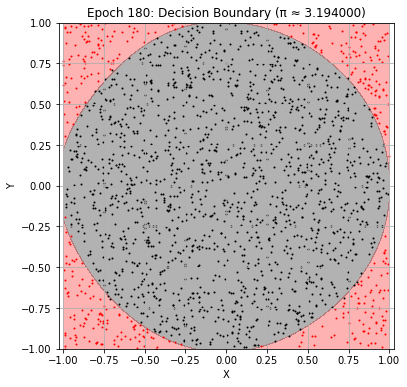

Epoch 190: Val Loss = 0.0324, π ≈ 3.184000
Epoch 200: Val Loss = 0.0292, π ≈ 3.214000
Epoch 210: Val Loss = 0.0277, π ≈ 3.188000


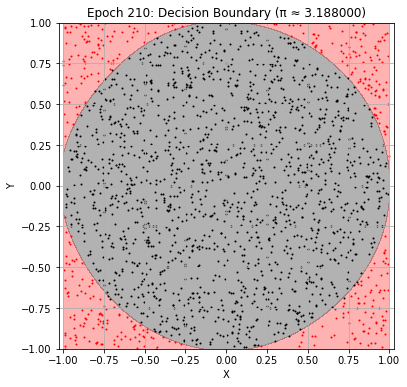

Epoch 220: Val Loss = 0.0267, π ≈ 3.224000
Epoch 230: Val Loss = 0.0252, π ≈ 3.208000
Epoch 240: Val Loss = 0.0245, π ≈ 3.216000


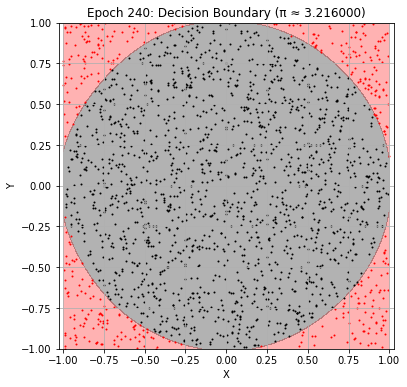

Epoch 250: Val Loss = 0.0235, π ≈ 3.208000
Epoch 260: Val Loss = 0.0249, π ≈ 3.176000
Epoch 270: Val Loss = 0.0222, π ≈ 3.212000


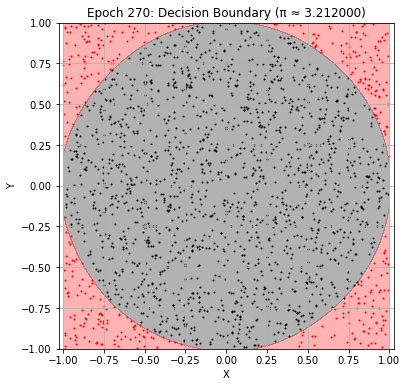

Epoch 280: Val Loss = 0.0226, π ≈ 3.222000
Epoch 290: Val Loss = 0.0225, π ≈ 3.174000
Epoch 300: Val Loss = 0.0202, π ≈ 3.206000


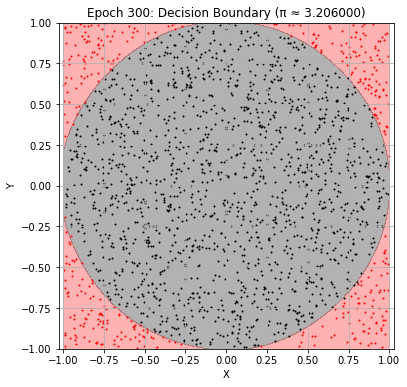

Epoch 310: Val Loss = 0.0240, π ≈ 3.182000
Epoch 320: Val Loss = 0.0186, π ≈ 3.200000
Epoch 330: Val Loss = 0.0192, π ≈ 3.190000


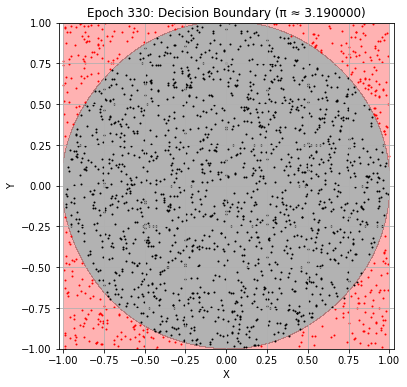

Epoch 340: Val Loss = 0.0177, π ≈ 3.200000
Early stopping!


In [7]:
# Train loop with visual updates
epochs = 600
patience = 12
best_val_loss = float('inf')
best_epoch = 0
wait = 0

for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            val_loss += criterion(model(xb), yb).item()
    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)

    pi_est = estimate_pi(model, val_loader)
    pi_history.append(pi_est)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Val Loss = {val_loss:.4f}, π ≈ {pi_est:.6f}")

    # Update best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break

    # Plot every 30 epochs
    if (epoch + 1) % 30 == 0:
        plot_decision_boundary(model, epoch)


- **Final Plot:**  As the early stopping has occured now we can plot the best trained network, which is saved during training and see the estimate of $\pi$.


Best result at epoch 332: π ≈ 3.200000 (val_loss: 0.017568)


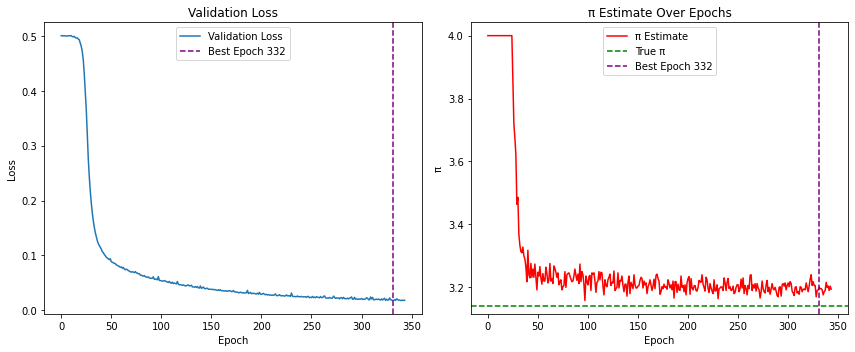

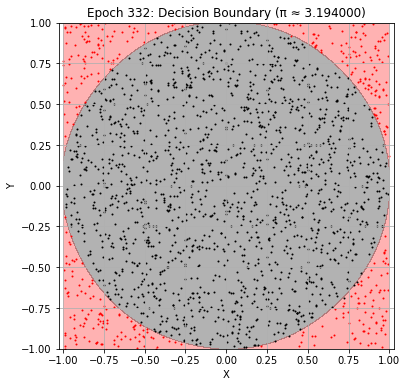

In [8]:
# Final plots after training
model.load_state_dict(best_model_state) # This is the best model saved by the early stopping 
print(f"\nBest result at epoch {best_epoch+1}: π ≈ {pi_history[best_epoch]:.6f} (val_loss: {val_loss_history[best_epoch]:.6f})")

# Plot loss and π estimate history
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(val_loss_history, label="Validation Loss")
plt.axvline(x=best_epoch, color='purple', linestyle='--', label=f'Best Epoch {best_epoch+1}')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Validation Loss")

# π Estimate
plt.subplot(1, 2, 2)
plt.plot(pi_history, color='red', label="π Estimate")
plt.axhline(y=np.pi, color='green', linestyle='--', label="True π")
plt.axvline(x=best_epoch, color='purple', linestyle='--', label=f'Best Epoch {best_epoch+1}')
plt.xlabel("Epoch")
plt.ylabel("π")
plt.legend()
plt.title("π Estimate Over Epochs")

plt.tight_layout()
plt.show()

# Final decision boundary
plot_decision_boundary(model, best_epoch)
